# Logo Detection

In this notebook we develop a model which is able to locate and lable company logos within static images.

## Import dependencies

In [1]:
import os
import json
import random

import cv2
import pandas as pd
import matplotlib.pylab as plt
from IPython.display import Image

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [2]:
from summitutils import training

## Load in the training data

The training data was simulated by applying transformations to the logos and laying them on top of various backgrounds. See [this notebook](./Training.ipynb) for more information on how the training data was simulated.

In the next cell we load in the information about the training data. For each image in the training set this information includes:
1. the file name,
2. the logo lables, 
3. the coordinates of the lower left and upper right corners of the bounding box,

In [7]:
logo_train = training.get_dicts('logo_detector_realbkg_large_expanded/combined/train')

logo_train_metadata = training.get_metadata('logo_detector_realbkg_large_expanded/combined_train')

training_info = pd.read_csv('logo_detector_realbkg_large_expanded/combined/train/labels.csv')

labels = list(training_info['class'].unique())

In [23]:
print("There are %d images in the training set."  %training_info.shape[0])

There are 5120 images in the training set.


['sas', 'rh', 'anaconda', 'cloudera']


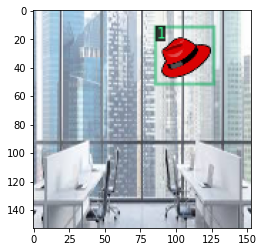

In [4]:
random.seed("summit20")
training.sample_plot(logo_train, logo_train_metadata,'./', label_scale=0.3)
print(labels)

## Training the model

In [5]:
def prepare_for_training(N_iter,
                         output_dir,
                         train_dataset_name,
                         N_classes,
                         start_training=False):
    cfg = get_cfg()
    cfg.MODEL.DEVICE='cpu'
    cfg.merge_from_file(model_zoo.get_config_file\
                        ("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url\
                        ("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  
    cfg.SOLVER.MAX_ITER = N_iter   
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = N_classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)

    if start_training:
        trainer.train()

    return trainer, cfg 

In [6]:
training.register('logo_detector_realbkg_large_expanded/combined/', labels, ['train', 'test'])

N_classes = 4
trainer, cfg = prepare_for_training(2, 
                                    'logo_detector_realbkg_large_expanded', 
                                    'logo_detector_realbkg_large_expanded/combined/_train', 
                                    N_classes, 
                                    start_training=True)

[04/05 16:57:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[04/05 16:57:58 d2.data.build]: Removed 0 images with no usable annotations. 5120 images left.
[04/05 16:57:59 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    sas     | 1280         |     rh     | 1280         |  anaconda  | 1280         |
|  cloudera  | 1280         |            |              |            |              |
|   total    | 5120         |            |              |            |              |
[04/05 16:57:59 d2.data.common]: Serializing 5120 elements to byte tensors and concatenating them all ...
[04/05 16:57:59 d2.data.common]: Serialized dataset takes 1.24 MiB
[04/05 16:57:59 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/05 16:57:59 d2.data

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (5, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (16, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[04/05 16:57:59 d2.engine.train_loop]: Starting training from iteration 0
[04/05 16:59:11 d2.utils.events]:  eta: N/A  iter: 1  total_loss: 2.046  loss_cls: 1.457  loss_box_reg: 0.329  loss_rpn_cls: 0.231  loss_rpn_loc: 0.029    data_time: 0.9892  lr: 0.000000  
[04/05 16:59:11 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


## Validating the model

Next, we see how well our model we just trained performs on labled data.

In [36]:
def prepare_for_inference(cfg, test_dataset_name, threshold=0.70):
    print(f"Reading weights from output dir: {cfg.OUTPUT_DIR}")
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.DATASETS.TEST = (test_dataset_name, )
    predictor = DefaultPredictor(cfg)    

    return predictor


def infer_img(predictor, img_filename, metadata):
    img = cv2.imread(img_filename)
    outputs = predictor(img)

    v = Visualizer(img[:,:,::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    
    return outputs

In the next cell, we load in test data and define a threshold of certainty which must be met for a bounding box to be drawn. 

In [33]:
predictor = training.prepare_for_inference(cfg, 'logo_detector_realbkg_large_expanded/combined/test/', threshold=0.34)
logo_test_metadata = training.get_metadata('logo_detector_realbkg_large_expanded/combined/test')

Reading weights from output dir: logo_detector_realbkg_large_expanded


Inspecting an image:

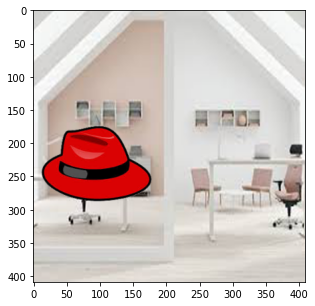

In [37]:
plt.figure(figsize=(5,5))
_ = infer_img(predictor, 'logo_detector_realbkg_large_expanded/combined/test/rh_aanahw.png', logo_test_metadata)

### Performance Metrics

We look at two perfomance metrics for the model: The first is a confusion matrix, showing the proportion of correctly classified and missclasified logos; the second is the average overlap between the bounding boxes drawn on our training data and the boxes identified by the model.

'sas': 82.5824281290984,
'rh': 79.00924387840708,
'anaconda': 86.84715918153037,
'cloudera': 70.13753486443517

### Testing on new data

In [ ]:
Image(filename='./Summit-2.png', width=800, height=800)

In [ ]:
Image(filename='./Summit-3.png', width=800, height=800)

## Publish the model

This is a two stage process:
1. save model binary to ceph bucket
2. submit a PR showing the model performance data

In [ ]:
out = json.dumps({'accuracy': 0.8})
METRIC_FILE = '../outputs/metrics'
with open(METRIC_FILE, 'w') as f:
    f.write(out)